# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [58]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

import datetime
from scipy.io import loadmat
from sklearn import metrics


%matplotlib inline
%config InlineBackend.figure_format='retina'



In [59]:
df = pd.read_csv('./trainset/J0003_0024_0222_20110307012737_cell_1.csv')

df['일자'] = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
df['연도'] =df['일자'].dt.year
df['월'] =df['일자'].dt.month
df['일'] =df['일자'].dt.day

In [60]:
df.tail(5)

,CellNo,Resistance,Volt,Temp,일자,연도,월,일
254,1,0.301,2.23,-20,2011-08-30 05:28:00,2011,8,30
255,1,0.301,2.23,-20,2011-08-30 17:28:00,2011,8,30
256,1,0.302,2.23,-20,2011-08-31 05:28:00,2011,8,31
257,1,0.300,2.23,-20,2011-08-31 16:09:00,2011,8,31
258,1,0.296,2.23,-20,2011-08-31 16:12:00,2011,8,31


In [61]:
xcolumn = ['Resistance','Volt','Temp']
ycolumn = ['Resistance']

#x = df[xcolumn]
#y = df[ycolumn]
'''
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler(feature_range=(0,1))
# X scaler 생성
xscaler = scaler.fit(x)
# Y scaler 생성
yscaler = scaler.fit(y)

# 스케일링 적용
trainX = xscaler.transform(x)
trainY = yscaler.transform(y)

#df_scaled = scaler.fit_transform(df[scale_cols])
'''
scaler = MinMaxScaler()
scale_cols = ['Resistance','Volt','Temp']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)

df_scaled.columns = scale_cols

trainX = df_scaled[xcolumn]
trainY = df_scaled[ycolumn]

trainX = pd.DataFrame(trainX)
trainY = pd.DataFrame(trainY)
#trainX.columns = xcolumn
#trainY.columns = ycolumn

print(trainX.tail())
print('----')
print(trainY.tail())

     Resistance  Volt  Temp
254    0.977273   0.0   0.0
255    0.977273   0.0   0.0
256    1.000000   0.0   0.0
257    0.954545   0.0   0.0
258    0.863636   0.0   0.0
----
     Resistance
254    0.977273
255    0.977273
256    1.000000
257    0.954545
258    0.863636


(259, 3)


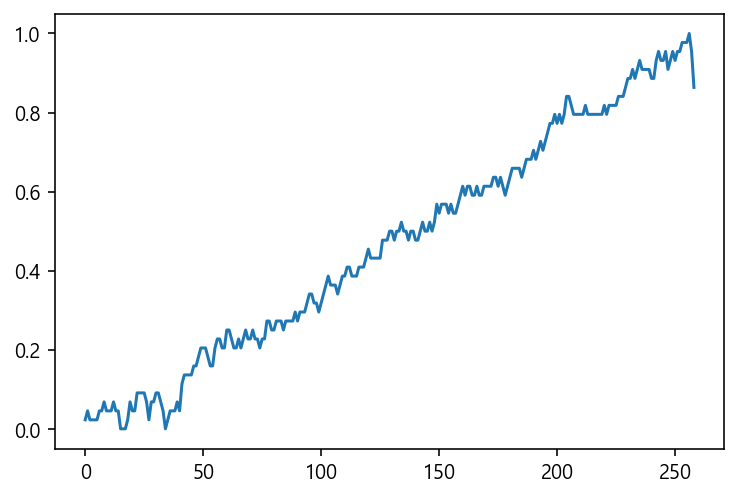

In [62]:
'''
test_data_size = 30

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]
'''
#sohs = ['time']
#trainX = df_scaled[xcolumn]
#trainY = df_scaled[ycolumn]

print(trainX.shape)
plt.plot(trainY)
plt.show()

In [63]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(trainX, trainY, test_size=0.2)

In [64]:
'''
# 테스트 데이터 수
test_data_size = 20
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']
'''

"\n# 테스트 데이터 수\ntest_data_size = 20\n# X변수들과 y변수 구분\nX = df[X_cols]\ny = df['target']\n"

In [65]:
'''
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()
'''

'\n# MinMaxScaler을 통한 스케일링\nscaler = MinMaxScaler()\n# X scaler 생성\nXscaler = scaler.fit(X)\n# Y scaler 생성\nyscaler = scaler.fit(y.values.reshape(-1,1))\n\n# 스케일링 적용\nX = Xscaler.transform(X)\ny = yscaler.transform(y.values.reshape(-1,1))\n\n# Train, Test set split\nX_train, X_test = X[:-test_data_size], X[-test_data_size:]\ny_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()\n'

In [66]:
x_train = np.array(x_train)
y_train= np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

print("train set : ", x_train.shape)
print("test set : ", x_valid.shape)

train set :  (207, 3)
test set :  (52, 3)


In [67]:
'''
sequence_length = 3
def make_batch(input_data, sl):
    train_x = []
    train_y = []
    L = len(input_data)
    for i in range(L-sl):
        train_seq = input_data[i:i+sl]
        train_label = input_data[i+sl:i+sl+1]
        train_x.append(train_seq)
        train_y.append(train_label)


def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res
'''

'\nsequence_length = 3\ndef make_batch(input_data, sl):\n    train_x = []\n    train_y = []\n    L = len(input_data)\n    for i in range(L-sl):\n        train_seq = input_data[i:i+sl]\n        train_label = input_data[i+sl:i+sl+1]\n        train_x.append(train_seq)\n        train_y.append(train_label)\n\n\ndef create_sequences1(array, seq_length):\n    res = []\n    if seq_length == 1:\n        for i in range(len(array)):\n            tmp=array[i:(i+seq_length)]\n            res.append(tmp)\n    else:\n        for i in range(len(array)-seq_length-1):\n            tmp = array[i:(i+seq_length)]\n            res.append(tmp)\n        \n    return res\n'

In [68]:
def create_sequences1(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [69]:
'''
train_x, train_y = make_batch(train_data_norm, sequence_length)
tensor_x = torch.Tensor(train_x)
tensor_y = torch.Tensor(train_y)


seq_length = 1

x_train = create_sequences1(x_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
x_valid = create_sequences1(x_valid, seq_length)
y_valid = create_sequences1(y_valid, seq_length)

tensor_x = torch.Tensor(x_train)
tensor_y = torch.Tensor(y_train)
'''

'\ntrain_x, train_y = make_batch(train_data_norm, sequence_length)\ntensor_x = torch.Tensor(train_x)\ntensor_y = torch.Tensor(train_y)\n\n\nseq_length = 1\n\nx_train = create_sequences1(x_train, seq_length)\ny_train = create_sequences1(y_train, seq_length)\nx_valid = create_sequences1(x_valid, seq_length)\ny_valid = create_sequences1(y_valid, seq_length)\n\ntensor_x = torch.Tensor(x_train)\ntensor_y = torch.Tensor(y_train)\n'

In [70]:
seq_length = 1

x_train = create_sequences1(x_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
x_valid = create_sequences1(x_valid, seq_length)
y_valid = create_sequences1(y_valid, seq_length)
x_train[:5]

[(array([[0., 0., 0.]]), array([[0.22727273, 0.        , 0.        ]])),
 (array([[0.22727273, 0.        , 0.        ]]), array([[0.5, 0. , 0. ]])),
 (array([[0.5, 0. , 0. ]]), array([[0.04545455, 0.        , 0.        ]])),
 (array([[0.04545455, 0.        , 0.        ]]),
  array([[0.84090909, 0.        , 0.        ]])),
 (array([[0.84090909, 0.        , 0.        ]]),
  array([[0.40909091, 0.        , 0.        ]]))]

In [71]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [72]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [73]:
print(model)


LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [74]:
epochs = 150

for i in range(epochs):
    for seq, labels in x_train:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

TypeError: view() takes at most 2 arguments (3 given)

In [49]:
tensor_x.size(), tensor_y.size()

(torch.Size([207, 1, 3]), torch.Size([207, 1, 1]))

In [50]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

print("x_train :",(x_train.shape))
print("x_valid :",(x_valid.shape))
print("y_train :",(y_train.shape))
print("y_valid :",(y_valid.shape))

x_train : torch.Size([207, 1, 3])
x_valid : torch.Size([52, 1, 3])
y_train : torch.Size([207, 1, 1])
y_valid : torch.Size([52, 1, 1])


# Building a Model

In [128]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [129]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(x_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(x_valid)
                test_loss = loss_fn(y_test_pred.float(), y_valid)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [130]:
# Hyper-parameter 설정
n_features=x_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=200

In [131]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, x_train, y_train, x_valid, y_valid, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.2176 test loss: 0.1784
Epoch 10 train loss: 0.1903 test loss: 0.1554
Epoch 20 train loss: 0.1651 test loss: 0.1348
Epoch 30 train loss: 0.1409 test loss: 0.1157
Epoch 40 train loss: 0.1173 test loss: 0.0985
Epoch 50 train loss: 0.0968 test loss: 0.0866
Epoch 60 train loss: 0.0875 test loss: 0.0881
Epoch 70 train loss: 0.0886 test loss: 0.0942
Epoch 80 train loss: 0.0874 test loss: 0.0895
Epoch 90 train loss: 0.0874 test loss: 0.0875
Epoch 100 train loss: 0.0873 test loss: 0.0879
Epoch 110 train loss: 0.0873 test loss: 0.0889
Epoch 120 train loss: 0.0873 test loss: 0.0889
Epoch 130 train loss: 0.0872 test loss: 0.0886
Epoch 140 train loss: 0.0872 test loss: 0.0885
Epoch 150 train loss: 0.0872 test loss: 0.0886
Epoch 160 train loss: 0.0872 test loss: 0.0886
Epoch 170 train loss: 0.0871 test loss: 0.0886
Epoch 180 train loss: 0.0871 test loss: 0.0886
Epoch 190 train loss: 0.0871 test loss: 0.0886


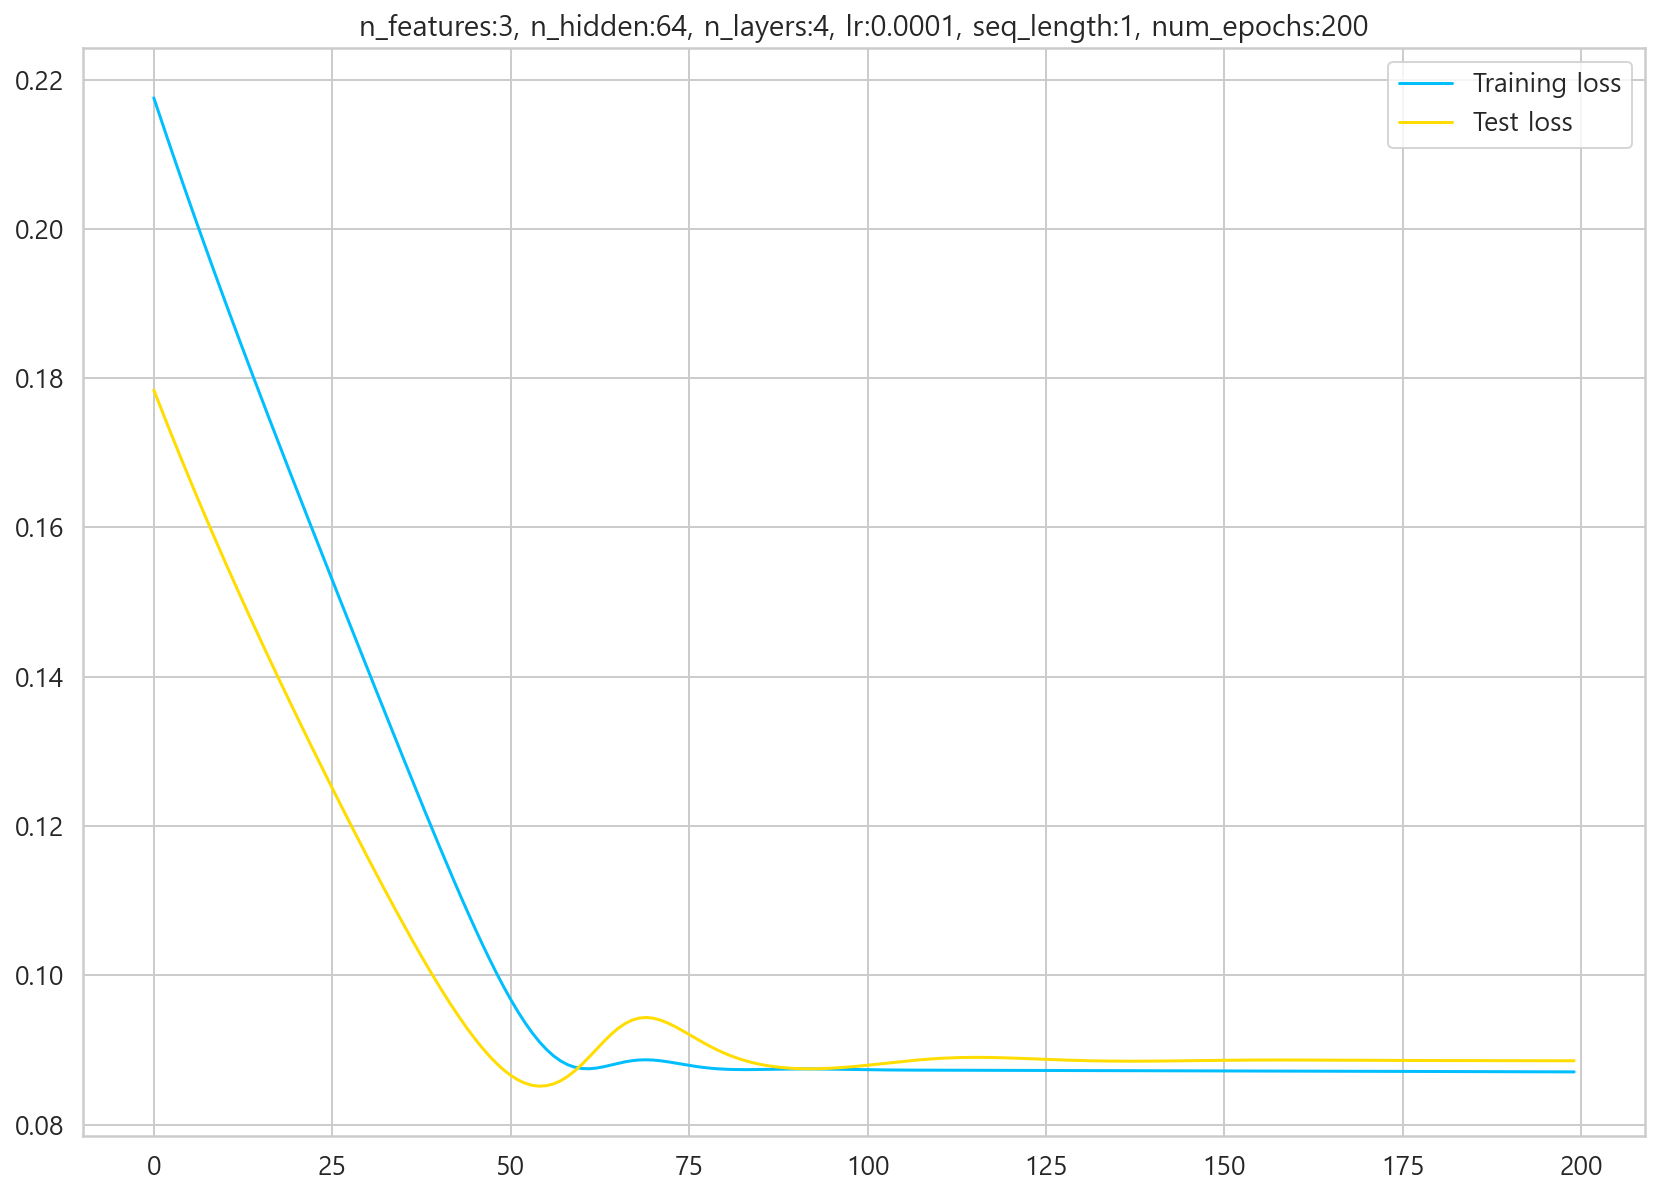

In [132]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# Predicting daily cases

In [133]:
with torch.no_grad():
    
    preds = []
    for i in range(len(x_valid)):
        test_seq = x_valid[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [134]:
preds

[0.4783724546432495,
 0.4783824384212494,
 0.4783795475959778,
 0.4783708155155182,
 0.4783596992492676,
 0.47834861278533936,
 0.4783379137516022,
 0.47832807898521423,
 0.47832006216049194,
 0.478313148021698,
 0.47830793261528015,
 0.478304386138916,
 0.47830089926719666,
 0.4782983362674713,
 0.4782964289188385,
 0.4782947897911072,
 0.47829368710517883,
 0.4782927930355072,
 0.47829172015190125,
 0.4782905876636505,
 0.47828957438468933,
 0.4782879948616028,
 0.47828561067581177,
 0.4782830774784088,
 0.47828057408332825,
 0.4782789647579193,
 0.47827744483947754,
 0.47827547788619995,
 0.47827309370040894,
 0.4782709777355194,
 0.4782697260379791,
 0.47826841473579407,
 0.47826752066612244,
 0.4782661199569702,
 0.47826528549194336,
 0.47826430201530457,
 0.4782634377479553,
 0.47826239466667175,
 0.4782613217830658,
 0.47826045751571655,
 0.4782595634460449,
 0.47825887799263,
 0.4782572388648987,
 0.47825488448143005,
 0.4782523214817047,
 0.47824978828430176,
 0.47824701666831

In [135]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [136]:
pred_values

array([[0.27904839],
       [0.27904883],
       [0.2790487 ],
       [0.27904832],
       [0.27904783],
       [0.27904734],
       [0.27904687],
       [0.27904644],
       [0.27904608],
       [0.27904578],
       [0.27904555],
       [0.27904539],
       [0.27904524],
       [0.27904513],
       [0.27904504],
       [0.27904497],
       [0.27904492],
       [0.27904488],
       [0.27904484],
       [0.27904479],
       [0.27904474],
       [0.27904467],
       [0.27904457],
       [0.27904446],
       [0.27904435],
       [0.27904427],
       [0.27904421],
       [0.27904412],
       [0.27904402],
       [0.27904392],
       [0.27904387],
       [0.27904381],
       [0.27904377],
       [0.27904371],
       [0.27904367],
       [0.27904363],
       [0.27904359],
       [0.27904355],
       [0.2790435 ],
       [0.27904346],
       [0.27904342],
       [0.27904339],
       [0.27904332],
       [0.27904321],
       [0.2790431 ],
       [0.27904299],
       [0.27904287],
       [0.279

In [137]:
pred_values_ceiled  = list(pred_values.flatten())

In [138]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_valid)[:, [-1]]

In [139]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':y_valid.flatten(),
                            'Pred':pred_values_ceiled})

In [140]:
score_table

,True,Pred
0,0.204545,0.279048
1,0.136364,0.279049
2,0.045455,0.279049
3,0.227273,0.279048
4,0.477273,0.279048
5,0.363636,0.279047
6,0.818182,0.279047
7,0.863636,0.279046
8,0.431818,0.279046
9,0.818182,0.279046


In [141]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [142]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

print(y_valid.size())

MSE : 0.10501117927477102, RMSE : 0.32405428445674195, SCORE : 59.850799121912026
torch.Size([52, 1])


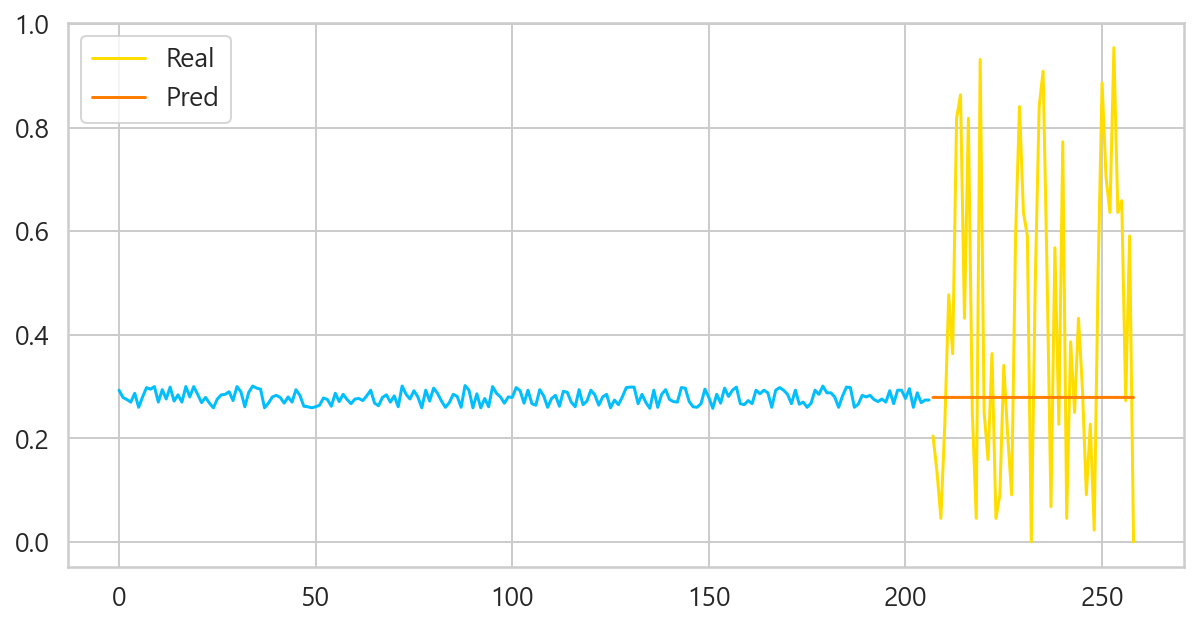

In [144]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_valid.__len__()),y_valid, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_valid.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [76]:
# 모델 저장
#PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
PATH = './models/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

torch.save(model, PATH)

In [77]:
# 모델 불러오기
#PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
model = torch.load(PATH)
#model.eval()

# Use all data for training

In [78]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['target']

In [79]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [80]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [81]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (102, 331)
y_all :  (102,)


In [82]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [83]:
# model = CoronaVirusPredictor(
#   n_features=n_features,
#   n_hidden=n_hidden,
#   seq_len=seq_length,
#   n_layers=n_layers
# )
# model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

# Predicting future cases

In [84]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [85]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [86]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[8.542214393615723,
 8.863585472106934,
 9.061980247497559,
 9.157882690429688,
 9.19661808013916,
 9.203207969665527,
 9.236523628234863,
 9.317728996276855,
 9.421761512756348,
 9.520094871520996,
 9.591507911682129,
 9.62355899810791,
 9.612334251403809,
 9.541833877563477]

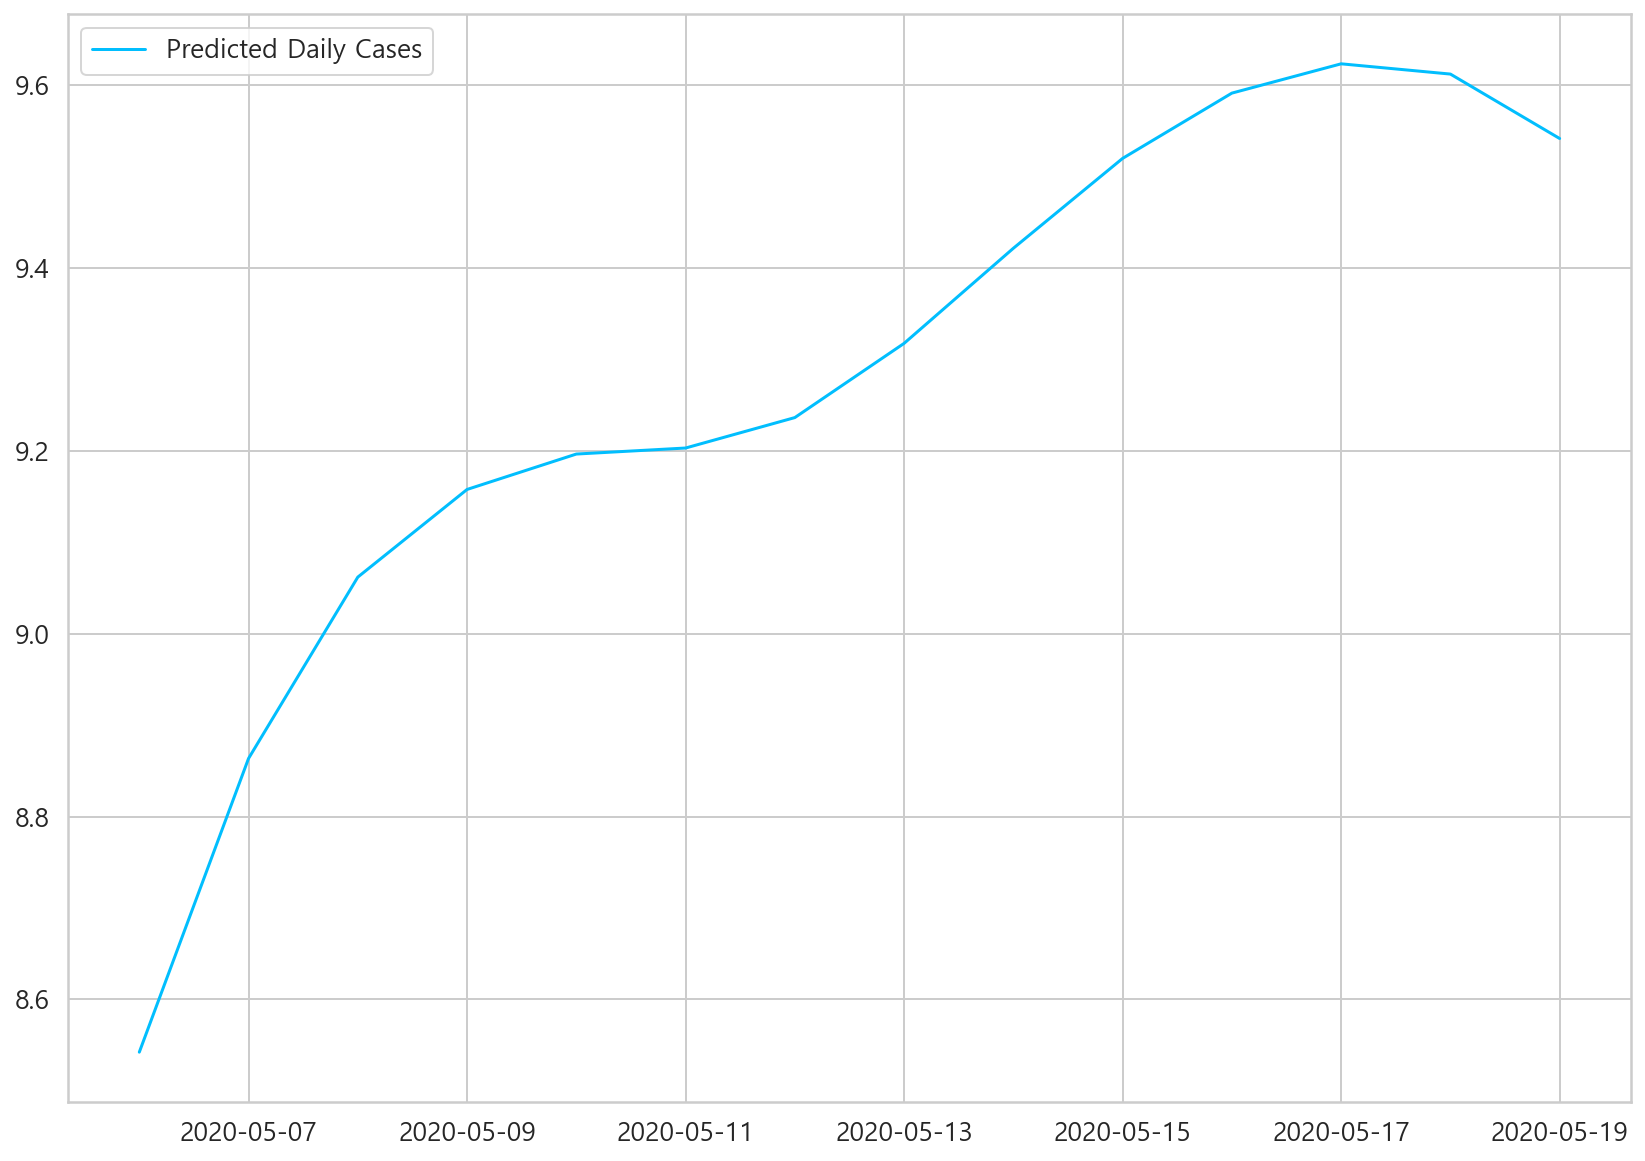

In [87]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [88]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [89]:
preds_

,0
2020-05-06,8.542214
2020-05-07,8.863585
2020-05-08,9.061980
2020-05-09,9.157883
2020-05-10,9.196618
2020-05-11,9.203208
2020-05-12,9.236524
2020-05-13,9.317729
2020-05-14,9.421762
2020-05-15,9.520095


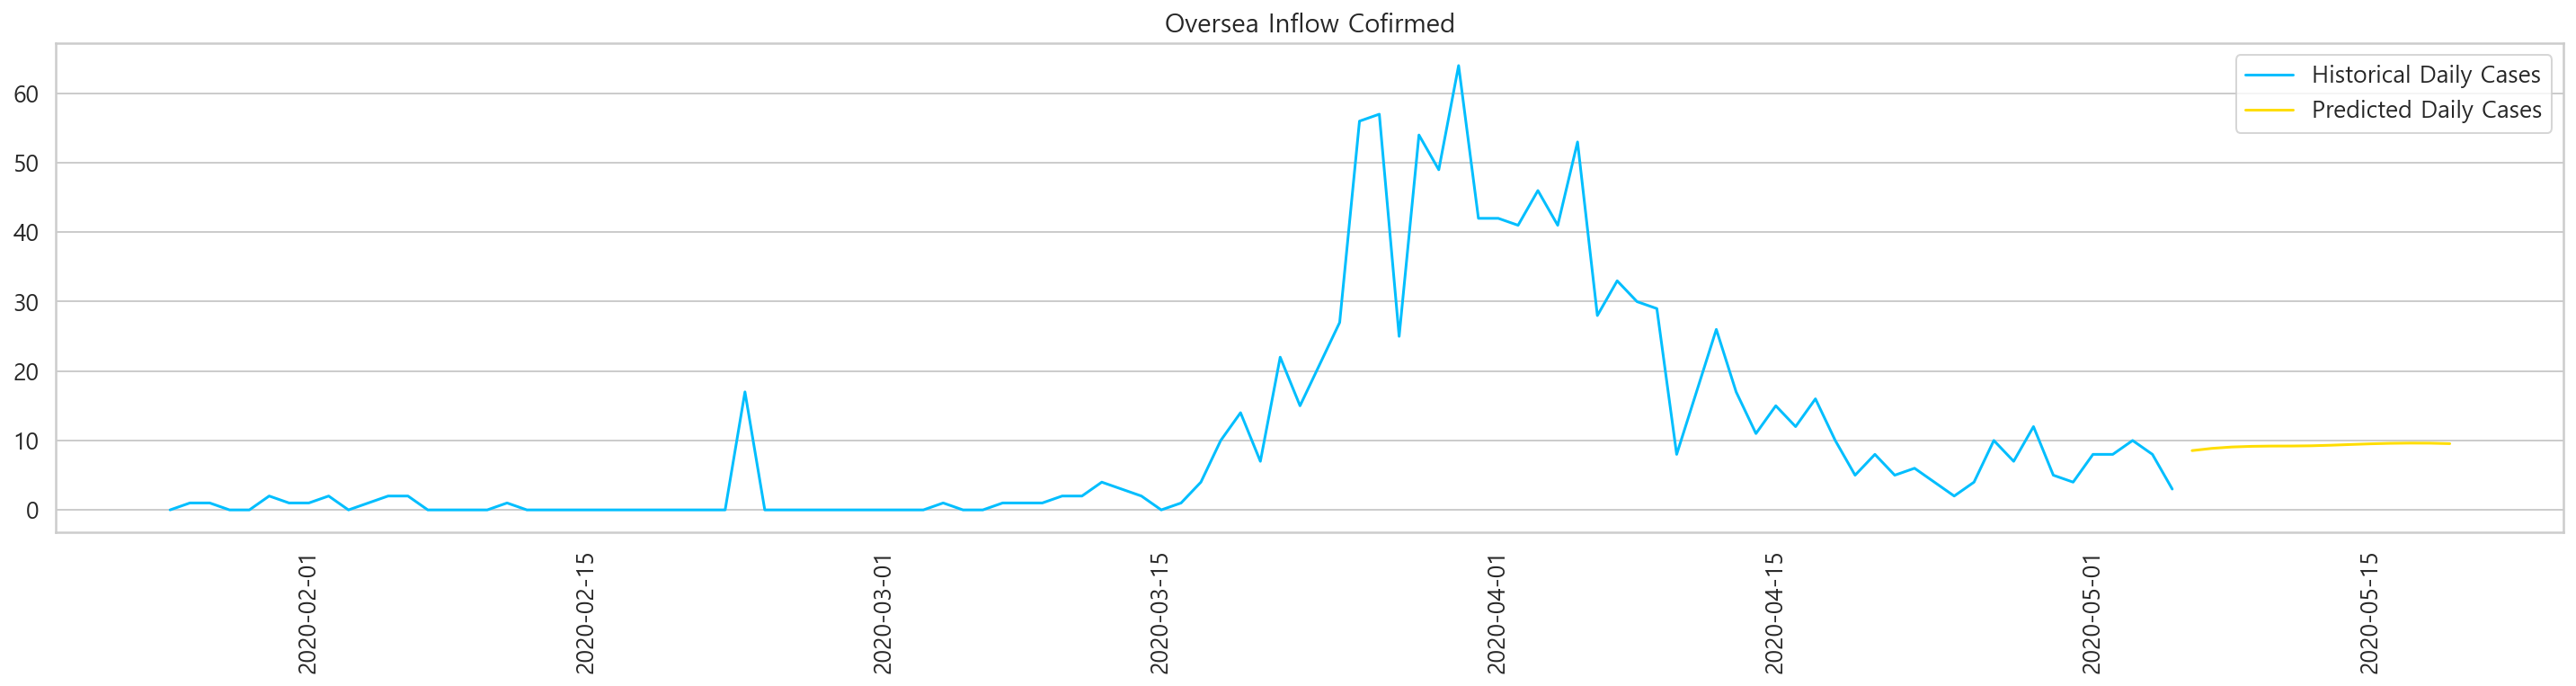

In [90]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();